## Using a Landscape Evolution Model. Part 2, Drainage Network in a Complex Landscape

This notebook illustrates how numerical landscape evolution models simulate change in the landscape over time. We start with a real landscape, imported from a digital elevation model of a landscape in Nebraska with high drainage density (many closely spaced valleys). The model then simulates evolution of this landscape over thousands of years, based on assumptions about the processes that erode this landscape. You can change the assumptions and see how that changes the resulting landscape. Using this particular real landscape is helpful for focusing on how different assumptions about processes change drainage density. The introductory material here describing how model works is the same as in *Using a Landscape Evolution Model. Part 1, A Single Ridge*.

This particular model is put together from components of Landlab 2.0, a toolbox for modeling earth surface processes and landscape evolution (Hobley et al., 2017). Landlab 2.0 has numerous components that can be combined in various ways and modified as needed, all in the Python language. You can look at the Python code in this notebook if you have programming experience, but it's not necessary to know how the code works to run the model or change some settings. Much of the code used here is adapted from Landlab tutorials and teaching notebooks created by Nicole Gasparini, Tulane University, based on models originally written by Andy Wickert (University of Minnesota), Greg Tucker (University of Colorado), and Stephen Lancaster (Oregon State University)

## Processes in the Model

You can think of the landscape in the model as a grid like the DEMs you've used in ArcGIS Pro, with an elevation assigned to each grid cell. As with a DEM in ArcGIS, Landlab code calculates the slope of each grid cell based on its elevation relative to its neighboring cells, and it can also calculate the drainage area upslope that contributes runoff to a grid cell. There are some details on how this is actually done in Landlab that are important in putting together a working model but they aren't important for our purposes here. The important point is Landlab has functions that take the upslope drainage area and/or slope and calculate net erosion or deposition of material at each. 

Processes considered in this model are grouped into two categories. **Diffusive processes** are those involving slow downhill movement of soil by creep, animal burrowing, and related mechanisms, all often assumed to occur at a rate proportional to the local slope. **Slopewash and fluvial processes** (just referred to as "fluvial processes" from here on, involve erosion and movement of soil and rock by flowing water. This can involve sheets or thin strands of water on a hillslope, or water flowing in a well-defined channel. For these processes, we assumed that the rate of downhill transport is a function of both the local slope and the upslope area contributing water to a given location on a hillslope or in a channel. *We won't consider mass wasting processes such as landslides or debris flows at all in this model*, although there are more complex landscape evolution models that do include them.

For **diffusive processes**, we can write a simple equation for the rate of downhill transport of soil ($Q_s$):

$$Q_s=-DS$$

*S* is the *local slope*, defined as fall in elevation/horizontal distance (this is the tangent of the slope angle, and written as a percentage it is also referred to as the "percent slope"). Note that we always measure *S* along the direction of steepest descent, and that *S* has a *negative value* because we are defining it in terms of negative change in elevation. *D* is a constant, that depends on local factors that influence downslope movement, such as the type of soil, vegetation cover, and climate. 

*Although this part is not essential to understand for this class, it may be interesting if you have enough background in calculus to understand it.* We could also write *S* as $\partial z/\partial x$ where *z* is elevation of the land surface and *x* is horizontal distance in the downslope direction. Then we could write the following equation for the rate of change of elevation over time ($\partial z/\partial t$) on the slope:

$$\frac{\partial z}{\partial t}= U + D\frac{\partial^2 z}{\partial x^2}$$

In this equation, $\partial^2 z/\partial x^2$ is the curvature of the slope (how fast it's getting steeper or less steep). $\partial^2 z/\partial x^2$ is negative when the slope is convex, getting steeper downhill, and is positive when the slope is concave. U is the tectonic uplift rate, which is positive. 

*Again, understanding this second equation is not essential for this course*. Instead, we can express what it means verbally like this: On a convex slope, diffusive processes cause net erosion. On a concave slope they cause net deposition of sediment, or upbuilding of the landsurface. Tectonic uplift will offset erosion, reducing the overall loss in elevation or even causing a net increase in elevation. Uplift will add together with net deposition of sediment, increasing the overall increase in elevation. 

Key points to remember on diffusive processes: 1) They produce a *convex slope* over time, 2) The rate of erosion is greater where convexity is greater (slope gets steeper downhill faster), 3)Erosion is offset by tectonic uplift, so the rate of change of surface elevation is related to D, curvature of the slope, and the tectonic uplift.

For **fluvial processes**, we use this equation for the rate of erosion (*e*) by flowing water at a particular point on a slope or in a channel: 

$$e=K_{sp} A^mS^n$$

In this equation, $K_{sp}$ is a constant related to the material being eroded and other local factors,and *A* is the area upslope or upstream that contributes water to the point of interest. *S* is land surface slope, defined the same way as for diffusive processes. Note that both *A* and *S* have exponents; *m* is often assumed to be 0.5 and *n* is often set at 1.0, although other values might apply in some cases. Lowering of the land surface by fluvial erosion can be offset by tectonic uplift in this case as well, so the change in land surface elevation will be a function of both the erosion rate and the uplift rate.

Using this equation to model fluvial processes essentially assumes that the erosion rate is proportional to *stream power*. As discussed in lecture, stream power is equal to stream discharge times slope. This equation uses the idea that discharge should be a function of drainage area (A). Using 0.5 for the value of *m* assumes that discharge is proportional to the square root of drainage area. An alternative way to model fluvial processes would be to assume that erosion is proportional to shear stress at the base of the flowing water, but we won't use that idea here.

Often, geomorphologists find evidence for a *threshold* value of stream power (or shear stress). That is, the stream power has to reach a certain level before any erosion can occur. In this model, the threshold stream power can be zero (the default) or somewhat higher.

## Using the Model

A. Now let's use the model. First, we have to load a number of parts of Python and Landlab that we need for this particular model. Don't change any of the code here, just run the code by clicking on the "run" symbol.

In [1]:
from landlab.components import LinearDiffuser
from landlab.components import FlowAccumulator, FastscapeEroder
from landlab.plot import imshow_grid
from landlab.io import read_esri_ascii
from matplotlib.pyplot import figure, show, plot, xlabel, ylabel, title
import warnings
warnings.filterwarnings('ignore')

B. Now we import a DEM that was created in ArcGIS and make it into the grid used for the model. No changes needed here either, just run the code.

In [2]:
(mg, z) = read_esri_ascii('lh_model.txt', name = 'topographic__elevation')
#mg.at_node.keys()
#['topographic__elevation']
for edge in (mg.nodes_at_top_edge, mg.nodes_at_bottom_edge, mg.nodes_at_left_edge, mg.nodes_at_right_edge):
    mg.status_at_node[edge] = mg.BC_NODE_IS_FIXED_VALUE

C. The next step is to set the values of $D$ (used to model diffusive processes) and $K_{sp}$ (used to model fluvial processes). Higher $D$ will make diffusive processes more effective, while higher $K_{sp}$ will do the same for fluvial processes. Neither $D$ or $K_{sp}$ should be set to zero for this lab. As explained in the lab instructions, we'll start by comparing two scenarios with two very different balances between diffusive and fluvial processes. Initially, $D$ is set at 0.0001 and $K_sp$ at 0.0002. Following the lab assignment instructions, you will change these for additional simulations after resetting the model. 

In [3]:
#set diffusion coefficient (initially set at 0.0001, can be varied between 0.0001 and 1.0)
D = 0.0001

#set stream power erosion coefficient (initially set at 0.0002, can be changed to a value between 0.0001 and 0.004)
Ksp = 0.0002

D. Now we set the stream power threshold. Initially, leave this at 0.0, but following the lab assignment instructions, you will later change it to a higher value. Leave the tectonic uplift rate at 0.0 for this lab.

In [4]:
#set stream power erosion threshold (originally set at 0, can be from 0 to 0.002)
threshold = 0.002

#set uplift rate, in meters per year (originally set at 0, can be varied between 0 and 0.10)
uplift_rate = 0.0

E. The following code block should be left unchanged; just run it as is. In it, we create a variable to keep track of erosion and deposition, and functions to simulate diffusive and fluvial processes step-by-step. The grid size and time steps of the model are set. The grid size is 2X2 meters. 

In [5]:
#create erosion-deposition logging variables
erode_dep = mg.add_zeros('node', 'erode_dep')
t_erode_dep = mg.add_zeros('node', 't_erode_dep')
    
fr = FlowAccumulator(mg, flow_director='D8')

#model diffusive hillslope processes
lin_diffuse = LinearDiffuser(mg, linear_diffusivity=D)

#model stream power-based erosion
erode = FastscapeEroder(mg, K_sp=Ksp, m_sp=0.5, n_sp=1.0, threshold_sp=threshold)

#set grid size, length scale, time scale (10 yrs per timestep, 
#5000 years total). Then calculate number of loops we'll need (nt) and
#uplift per 10-yr timestep
nrows = 292
ncols = 275
dx = 2.0
total_t = 10000
dt = 10
nt = int(total_t // dt)
uplift_per_step = uplift_rate * dt

F. As a final step before running the simulation, there is code to create a **map of the initial topography** and an **elevation profile** from north to south through the middle of the grid, both of which you should see below the code block when you run it.**You can copy or save any graphics produced here for use in your lab assignment report**

Text(0.5, 1.0, 'N-S cross section')

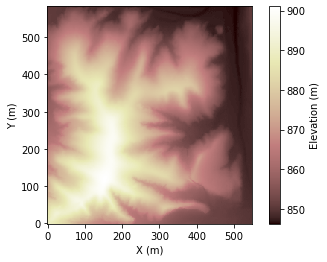

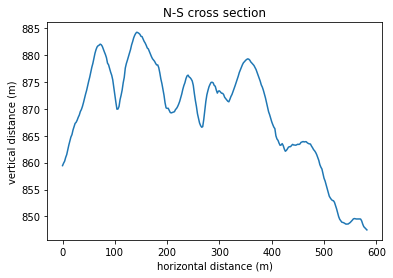

In [6]:
#Show initial landscape
figure('iniital surface')
imshow_grid(mg, 'topographic__elevation', grid_units=['m','m'], var_name='Elevation (m)')

#show initial cross profile
figure('topographic profile')
elev_rast = mg.node_vector_to_raster(z)
ycoord_rast = mg.node_vector_to_raster(mg.node_y)
ncols = mg.number_of_node_columns
im = plot(ycoord_rast[:, int(ncols // 2)], elev_rast[:, int(ncols // 2)])
xlabel('horizontal distance (m)')
ylabel('vertical distance (m)')
title('N-S cross section')

G. Now comes the actual simulation. No changes should be made in the code block below. Just run it, and you will see numbers from 0 to 1000 gradually appear showing how many time steps have been completed. **Be patient, it will take awhile**. It will run through 1000 timesteps, each one 10 years long, so a total of 10,000 simulated years of landscape change. 

In [7]:
#erosion by diffusion and stream power-based channel erosion and deposition, with uplift
mg.at_node['t_erode_dep']-=mg.at_node['t_erode_dep']
for i in range(nt+1):
    if i > 900:
        mg.at_node['erode_dep']-=mg.at_node['erode_dep']
        mg.at_node['erode_dep']+=mg.at_node['topographic__elevation']
    lin_diffuse.run_one_step(dt)
    fr.run_one_step()
    erode.run_one_step(dt)
    if i > 900:
        mg.at_node['erode_dep']-=mg.at_node['topographic__elevation']
        mg.at_node['t_erode_dep']+=mg.at_node['erode_dep']
    mg.at_node['topographic__elevation'][mg.core_nodes] += uplift_per_step
    if i % 200 == 0:
        print ('Completed loop %d' % i)
mg.at_node['t_erode_dep']=mg.at_node['t_erode_dep']*0.001

Completed loop 0
Completed loop 200
Completed loop 400
Completed loop 600
Completed loop 800
Completed loop 1000


H. Okay, let's see some results. First, a map of topography at the end of the simulation. Compare this with the initial topography. Below that we'll plot another north-south elevation profile through the middle of the grid at the end of the simulation. Compare this to the initial profile. Finally, a map of average erosion rates in the last 100 timesteps (= the last 1000 years). This is showing you where the landscape is eroding faster and slower, and how much variation there is in erosion rates across the landscape as a whole.

In [ ]:
#show new topography        
figure('topography')
imshow_grid(mg, 'topographic__elevation', grid_units=['m','m'], var_name='Elevation (m)')

#show new cross profile
figure('topographic profile')
elev_rast = mg.node_vector_to_raster(z)
ycoord_rast = mg.node_vector_to_raster(mg.node_y)
ncols = mg.number_of_node_columns
im = plot(ycoord_rast[:, int(ncols // 2)], elev_rast[:, int(ncols // 2)])
xlabel('horizontal distance (m)')
ylabel('vertical distance (m)')
title('N-S cross section')

#show map of erosion or deposition every 20 steps
figure('Erosion or Deposition')
imshow_grid(mg, 't_erode_dep', var_name='Ave. Erosion (m/yr), Last 1000 Years')